In [ ]:
import os
import numpy as np
import pandas as pd
import shutil
import torch
import torch.nn as nn
import time
import warnings
warnings.filterwarnings("ignore")
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from skimage import io
import torchvision
import cv2, time
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from albumentations import HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,Compose, GaussNoise
from albumentations.pytorch import ToTensor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/My Drive/wheat_head_detection')
print(os.getcwd())
!ls/


/content/drive/My Drive/wheat_head_detection
/bin/bash: ls/: No such file or directory


In [ ]:
# !git clone https://github.com/pytorch/vision

In [ ]:
# !cp -v vision/references/detection/* .

In [ ]:
#folder locations
train_csv = 'dataset/train_main.csv'
train_dir = 'dataset/images'

In [ ]:
df = pd.read_csv(train_csv)
df.head(3)

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1

In [ ]:
print(f'Total number of train images is {len(os.listdir(train_dir))}')
print(f'Shape of dataframe is {df.shape}')
print(f'Number of images in dataframe is {len(np.unique(df["image_id"]))}')
print(f'Number of train images with no bounding boxes {len(os.listdir(train_dir)) - len(np.unique(df["image_id"]))}')

Total number of train images is 3422
Shape of dataframe is (147793, 5)
Number of images in dataframe is 3373
Number of train images with no bounding boxes 49


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.6+ MB


In [ ]:
def process_bbox(df):
    """
    this function will take the dataframe and vertically stack the image ids  with no bounding boxes
    """
    df['bbox'] = df['bbox'].apply(lambda x: eval(x))
    df['x'] = df['bbox'].apply(lambda x: x[0])
    df['y'] = df['bbox'].apply(lambda x: x[1])
    df['w'] = df['bbox'].apply(lambda x: x[2])
    df['h'] = df['bbox'].apply(lambda x: x[3])
    df['x'] = df['x'].astype(np.float)
    df['y'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)
    df.drop(columns=['bbox'],inplace=True)

    return df

In [ ]:
df_new = process_bbox(df)
print(f'shape of dataframe after prerpocessing {df_new.shape}')
df_new.head()

shape of dataframe after prerpocessing (147793, 8)


image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

# splitting to train and test

In [ ]:
image_ids = df_new['image_id'].unique()
train_ids = image_ids[0:int(0.8*len(image_ids))]
val_ids = image_ids[int(0.8*len(image_ids)):]
print(f'Total images {len(image_ids)}')
print(f'No of train images {len(train_ids)}')
print(f'No of validation images {len(val_ids)}')

Total images 3373
No of train images 2698
No of validation images 675


In [ ]:
train_df = df_new[df_new['image_id'].isin(train_ids)]
val_df = df_new[df_new['image_id'].isin(val_ids)]
print(train_df.shape)
print(val_df.shape)

(122577, 8)
(25216, 8)


# Loading dataset

In [ ]:
def get_transforms(phase):
   """
   image transforms
   """
   list_transforms = []
   if phase == 'train':
      list_transforms.extend([
                       Flip(p=0.5)
                         ])
   list_transforms.extend([
                        ToTensor(),
                          ])
   # we will also pass format and labels for augmentation
   list_trfms = Compose(list_transforms,
                                 bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
   return list_trfms


In [ ]:
class WheatSet(Dataset):
  def __init__(self,df,image_dir,phase='train'):
    super().__init__()
    self.df = df
    self.image_dir = image_dir
    self.images = df['image_id'].unique()
    self.transforms = get_transforms(phase)


  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    image_name = self.images[idx] + '.jpg'
    image_path = os.path.join(self.image_dir,image_name)
    image_arr = cv2.imread(os.path.join(self.image_dir,image_name), cv2.IMREAD_COLOR)
    image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
    
    #normalize the image
    image_arr /= 255.0
    image_id = image_name.split('.')[0]
    point = self.df[self.df['image_id'] == image_id]
    
    # we have x_min,y_min,w and h. we will convert w and h to x_max and y_max.so we have(x_min,y_min,x_max,y_max)
    boxes = point[['x', 'y', 'w', 'h']].values
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

    # there is only one class
    labels = torch.ones((point.shape[0],), dtype=torch.int64)

    #area
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    area = torch.as_tensor(area, dtype=torch.float32)

    # suppose all instances are not crowd
    iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)

    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = torch.tensor(idx)
    target['area'] = area
    target['iscrowd'] = iscrowd


    if self.transforms:
       sample = {
          'image': image_arr,
          'bboxes': target['boxes'],
          'labels': target['labels']
                }
       sample = self.transforms(**sample)
    target['boxes'] =  torch.tensor(sample['bboxes'],dtype=torch.long)
    target['labels'] = labels
    image = sample['image']
    
    return image, target

In [ ]:
train_data = WheatSet(train_df,train_dir,phase='train')
val_data = WheatSet(val_df,train_dir,phase='validation')

print(f'Length of train data {len(train_data)}')
print(f'Length of validation data {len(val_data)}')

Length of train data 2698
Length of validation data 675


In [ ]:
for image,target in train_data:
  print(image.shape)
  print(target['boxes'][0])
  print(target['labels'][0])
  
  break

torch.Size([3, 1024, 1024])
tensor([834, 766, 890, 802])
tensor(1)


## visualization

In [ ]:
def image_convert(image):
    """
    image convert from torch to numpy
    """
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    """
    plotting image
    """
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes']
    for i in bb:
        x_min, y_min, x_max, y_max = map(int, i)
        cv2.rectangle(image, (x_min,y_min), (x_max,y_max), (0,255,0), thickness = 2) 
    plt.figure(figsize=(10,10))
    plt.imshow(image)

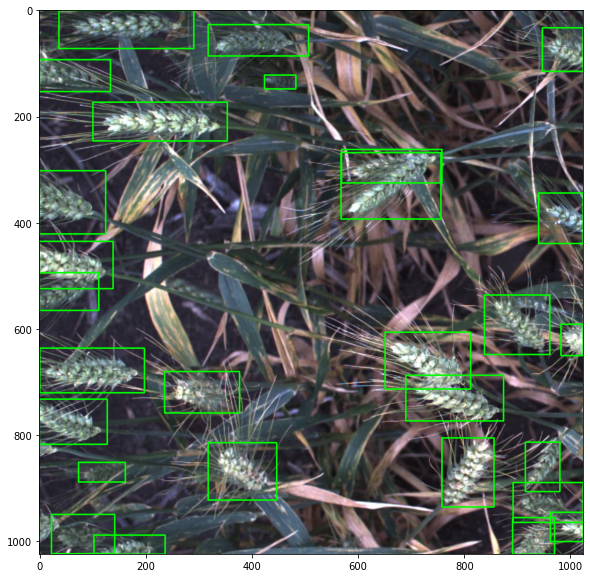

In [ ]:
plot_img(train_data,10)

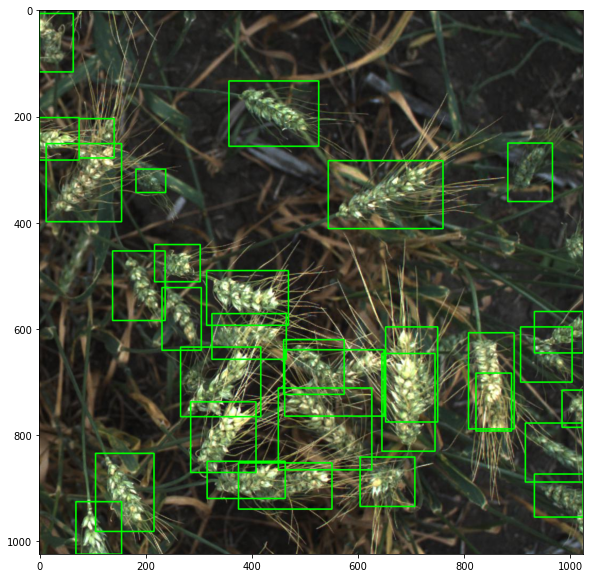

In [ ]:
plot_img(train_data,26)

# Batching

In [ ]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [ ]:
for image,target in train_data_loader:
  print(image[0].shape)
  break

torch.Size([3, 1024, 1024])


In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [ ]:
# setting the output dims of nwk

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)



In [ ]:
model = model.to(device)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

# Model training

In [ ]:

train_loss_min = 0.9

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)



In [ ]:
# from engine import evaluate,train_one_epoch

# num_epochs = 7
# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     evaluate(model, valid_data_loader, device=device)

In [ ]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [ ]:
from engine import evaluate



checkpoint_path = 'models/chkpoint_'
best_model_path = 'models/bestmodel_oct21.pt'

num_epochs = 8
valid_loss_min = 1

total_train_loss = []
total_valid_loss = []


for epoch in range(num_epochs):
  
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    model.train()
    for images, targets in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    #train_loss/len(train_data_loader.dataset)
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')
    # evaluate(model, train_data_loader, device=device)

    
    with torch.no_grad():
        valid_loss = []
        for images, targets in valid_data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            valid_loss.append(losses.item())        

    epoch_valid_loss = np.mean(valid_loss)
    total_valid_loss.append(epoch_valid_loss)
    print(f'Epoch validation loss is {epoch_valid_loss}')
  
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)
    # update the learning rate
    lr_scheduler.step()  

    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': epoch_valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_valid_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            valid_loss_min = epoch_valid_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))



Epoch :1
Epoch train loss is 0.9619553129701219
Epoch validation loss is 0.8692583680152893
creating index...
index created!
Test:  [ 0/85]  eta: 0:03:37  model_time: 0.4978 (0.4978)  evaluator_time: 0.4422 (0.4422)  time: 2.5562  data: 1.5461  max mem: 7553
Test:  [84/85]  eta: 0:00:00  model_time: 0.3987 (0.3974)  evaluator_time: 0.3342 (0.4918)  time: 0.7598  data: 0.0302  max mem: 7553
Test: Total time: 0:01:22 (0.9703 s / it)
Averaged stats: model_time: 0.3987 (0.3974)  evaluator_time: 0.3342 (0.4918)
Accumulating evaluation results...
DONE (t=0.46s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.452
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.851
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.440
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.466
 Average Precision  

In [ ]:
!ls

coco_eval.py		      README.md
coco_utils.py		      tf_api
dataset			      traffic_light_detection_frcnn_resnet50.ipynb
engine.py		      train.py
faster_rcnn_wheat_head.ipynb  transforms.py
group_by_aspect_ratio.py      utils.py
model_			      vision
__pycache__


In [ ]:
#saving the model
torch.save(model.state_dict(),'model_')

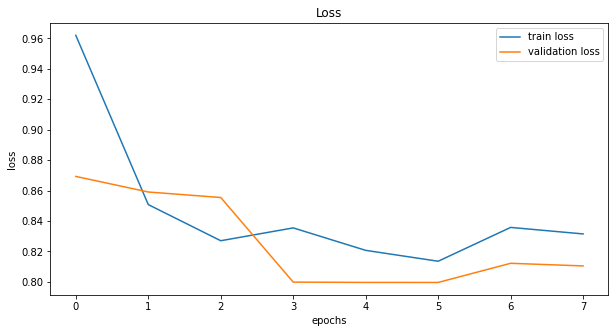

In [ ]:
plt.figure(figsize=(10,5))
plt.title('Loss')
plt.plot(total_train_loss,label='train loss')
plt.plot(total_valid_loss,label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Inference

In [67]:
def get_transforms():
    list_transforms = []
    list_transforms.extend(
                    [
        
            ToTensor(),
                    ])
    list_trfms = Compose(list_transforms)
    return list_trfms





class TestData(Dataset):
  def __init__(self,image_dir,val_df):
    self.val_df = val_df
    self.image_dir = image_dir
    self.images = val_df['image_id'].unique()  
    self.transforms = get_transforms()
    
  def __len__(self):
    return len(self.images)

  def __getitem__(self,idx):
    image = str(self.images[idx]) + '.jpg' 
    image_arr = io.imread(os.path.join(self.image_dir,image))
    image_id = str(image.split('.')[0])
        
    if self.transforms:
            sample = {
                'image': image_arr,
            }
            sample = self.transforms(**sample)
    image = sample['image']
               
    return image, image_id

In [68]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dir = 'dataset/images'

test_dataset = TestData(test_dir,val_df)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [69]:
for image, id in test_data_loader:
  print(image[0].shape)
  print(id)
  break

torch.Size([3, 1024, 1024])
('33ea56e1c', 'd728e2fc2', 'b5e726c10', '2ff4e8bb0')


In [70]:
# Defining model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# setting the output dims of nwk
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# Load the trained weights
weights = 'models/bestmodel_oct21.pt'
checkpoint = torch.load(weights,map_location=device)
model.load_state_dict(checkpoint['state_dict'])

model = model.to(device)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [98]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)



model.eval()
detection_threshold = 0.5
results = []
for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)
    
    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        # geting width and height
        # boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        # boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
     
        results.append(result)

In [99]:
predicted_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
print(predicted_df.shape)
predicted_df.head(3)



(675, 2)


image_id                                   PredictionString
0  33ea56e1c  0.9947 503 60 586 162 0.9922 843 81 920 187 0....
1  d728e2fc2  0.9903 949 598 1024 691 0.9897 924 943 1023 10...
2  b5e726c10  0.9936 927 174 1023 259 0.9832 866 528 999 612...

In [104]:
def plot_prediction(idx):
  image_id = predicted_df['image_id'][idx]
  boxes = predicted_df['PredictionString'][idx]
  boxes = np.array([float(i) for i in boxes.split()]).reshape(-1,5)
  image_path = str(image_id) + '.jpg'
  image_path = os.path.join('dataset/images',image_path)


  img = cv2.imread(image_path)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  for box_ in boxes:

      box = [int(i) for i in box_[1:]]
      cv2.rectangle(img, (box[0],box[1]), (box[2],box[3]), color=(255,0,0), thickness=2) 
      cv2.putText(img, str(box_[0]),(box[0]-10,box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

  plt.figure(figsize=(20,12))
  plt.imshow(img)
  plt.show()

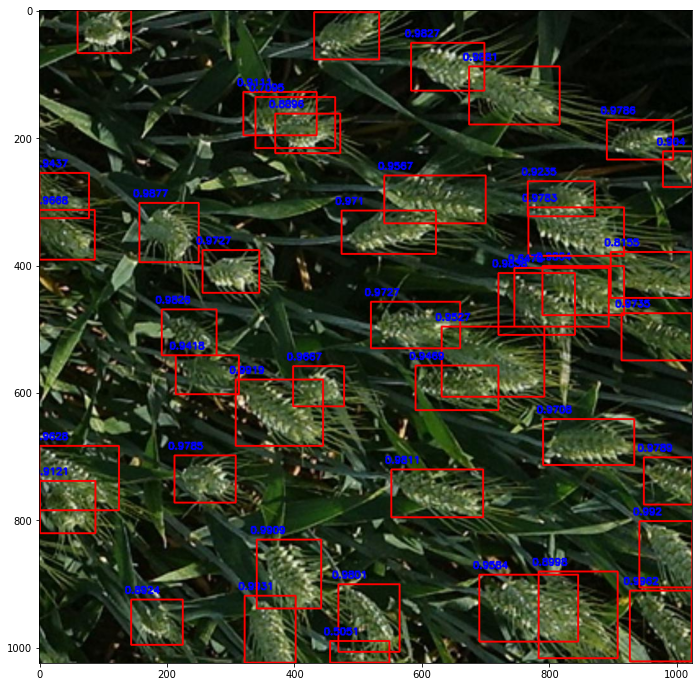

In [105]:
plot_prediction(10)

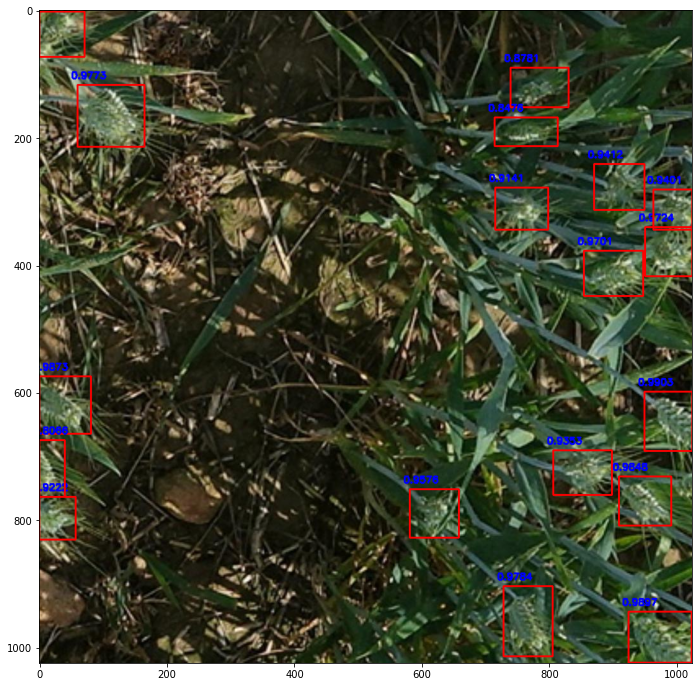

In [106]:
plot_prediction(1)

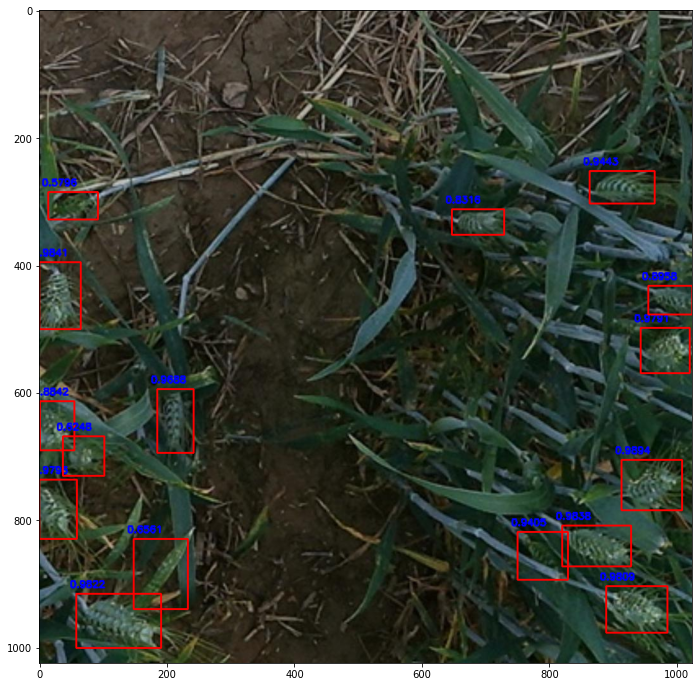

In [107]:
plot_prediction(12)

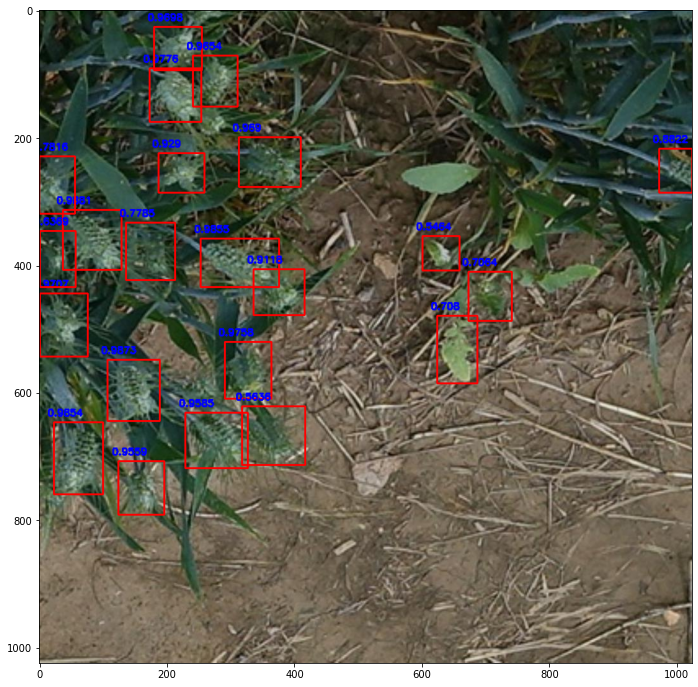

In [109]:
plot_prediction(4)

# Conclusion


* We used resnet 50 as backbone for our model initialized with  imagenet weights.
* On training,our model converges at 6th epoch and got an validation mAp of about 0.83.
* We can see that on training, our faster rcnn our models does an descent job.